# Assembling

This notebook is used to assemble a processable h5ad object for subsequent notebooks.

## Fill in input data, output and settings

In [1]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed' # specify the output directory of the processing should be the same in every notebook
test = 'all' # sample name, this should be the same for all the notebooks

In [28]:
################### DEFINING STRATEGY ###############################
from_h5ad = True #option 1
assembling_10_velocity = False #option 2
assembling_10_public = False #option 3
convert_seurat = False #option 4

###################### INPUT DATA ###################################

# For option 1: The path to an existing .h5ad file
h5ad_files = ['/mnt/workspace/jdetlef/data/anndata/Esophagus.h5ad']
#h5ad_files = ['/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Glaser_11_22/preprocessing_output/data/all_annotated_peaks.h5ad']
merge_column='sample' # (str) if multiple h5ad files merged this is an identifier from which file it originates
coordinate_cols=None # (list:str) columns where peak location data is stored (['chr', 'start', 'end'])
set_index=True # (boolean) should the adata.var index be formatted, that it matches chr:start-stop
index_from='name' # (str) should the index be generated from a certain column. Otherwise this is None (SnapATAC: name)

# Manually set existing QC Columns
n_features_by_counts = None
log1p_n_features_by_counts = None
total_counts = None
log1p_total_counts = None
mean_insertsize = None
insertsize_count = None
n_total_fragments = None
n_fragments_in_promoters = None
pct_fragments_in_promoters = None
blacklist_overlaps = None
# total_number_of_fragments
TN = None # 'TN'
# uniquely_mapped_fragments
UM = None # 'UM'
# properly_paired_fragments
PP = None # 'PP'
# uniq_fragments
UQ = None # 'UQ'
# chrM_fragments
CM = None # 'CM'

#################### Calc QC Columns ###############################
# set available number of threads
n_threads = 8

# Step 1: QC Metrics
calc_qc_metrics = True # set True if the QC metrics should be calculated 

# Step 2 & 3
use_bam = False # False if fragments should be used
barcode_tag = 'CB' # set the tag where to find the barcode to use
# if Step 2, 3 or both is executed specify either a BAM file or a fragments file:
bam_file = '/mnt/workspace/jdetlef/ext_ana/ext442/all.bam' # specify bamfile of the corresponding alignment
fragments_file = '/mnt/workspace/jdetlef/ext_ana/ext442/all_fragments_sorted.bed' # specify fragments file (if this is possible use the fragments file directly)

# Step 2: Mean Insertsizes
calc_mean_insertsize = True # set True if the mean insertsize should be calculated

# Step 3: Promotor-enrichment
calc_promotor_enrichment = True # set True if the promotor-enrichment should be calculated
# specify promotors_gtf if another promoter than the fixed ones should be used
# if promotors is None please specify species
promoters_gtf = '/mnt/workspace/jdetlef/ext_ana/mus_musculus.104.promoters2000.gtf'
species = None

## Import modules

In [29]:
# sctoolbox modules 
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.fragment_length as fragments
import sctoolbox.atac as atac
import sctoolbox.calc_overlap_pct as overlap
import sctoolbox.analyser 
from sctoolbox.qc_filter import *
from sctoolbox.atac_utils import *
# import episcanpy
import episcanpy as epi

## Setup path handling object 

In [30]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Read in data

### Option 1: Read from .h5ad

In [31]:
qc_columns = {}
qc_columns["n_features_by_counts"] = n_features_by_counts
qc_columns["log1p_n_features_by_counts"] = log1p_n_features_by_counts
qc_columns["total_counts"] = total_counts
qc_columns["log1p_total_counts"] = log1p_total_counts
qc_columns["mean_insertsize"] = mean_insertsize
qc_columns['n_total_fragments'] = n_total_fragments
qc_columns['n_fragments_in_promoters'] = n_fragments_in_promoters
qc_columns['pct_fragments_in_promoters'] = pct_fragments_in_promoters
qc_columns["blacklist_overlaps"] = blacklist_overlaps
qc_columns["TN"] = TN
qc_columns["UM"] = UM
qc_columns["PP"] = PP
qc_columns["UQ"] = UQ
qc_columns["CM"] = CM

In [32]:
if from_h5ad:
    
    adata = assemble_from_h5ad(h5ad_files,
                       qc_columns,
                       merge_column=merge_column,
                       coordinate_cols=coordinate_cols,
                       set_index=set_index,
                       index_from=index_from)

Index(['peak_chr', 'peak_start', 'peak_end'], dtype='object')
add existing adata.obs columns to infoprocess:

setting adata.obs.index = adata.obs[barcode]


## Inspect adata

In [33]:
display(adata)

AnnData object with n_obs × n_vars = 73652 × 174285
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample'
    var: 'peak_chr', 'peak_start', 'peak_end'
    uns: 'infoprocess', 'color_set'

In [34]:
display(adata.var)

,peak_chr,peak_start,peak_end
chr1:10005-10731,chr1,10005,10731
chr1:11169-11386,chr1,11169,11386
chr1:28730-29439,chr1,28730,29439
chr1:29492-29686,chr1,29492,29686
chr1:34644-35030,chr1,34644,35030
...,...,...,...
chrY:57203298-57203493,chrY,57203298,57203493
chrY:57206407-57206560,chrY,57206407,57206560
chrY:57215319-57215415,chrY,57215319,57215415
chrY:57215519-57215848,chrY,57215519,57215848


In [35]:
display(adata.obs)

,TN,UM,PP,UQ,CM,file,sample
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACGTCCCGTT,6223.0,5232.0,5214.0,3780.0,18.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
TTCCATCCTCTTTCTGGCGCAG,17.0,5.0,5.0,5.0,1.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1
TTCCATCCTCTTTGCCGGAAGG,8.0,7.0,7.0,7.0,0.0,/mnt/workspace/jdetlef/data/anndata/Esophagus....,sample1


## Calculate missing columns

In [36]:
check_barcode_tag(adata, bam_file, barcode_tag)

Consider if you are using the wrong column for cb-tag or bamfile. 
The following process can take several hours


### 1. calculate scanpy qc_metrics (n_features)

In [11]:
if qc_columns['n_features_by_counts'] is None or qc_columns['log1p_n_features_by_counts'] is None and calc_qc_metrics:
    adata = analyser.calculate_qc_metrics(adata, var_type='features')
    
    qc_columns['n_features_by_counts'] = 'n_features_by_counts'
    qc_columns['log1p_n_features_by_counts'] = 'log1p_n_features_by_counts'
    qc_columns['total_counts'] = 'total_counts'
    qc_columns['log1p_total_counts'] = 'log1p_total_counts'
    
    build_legend(adata, 'n_features_by_counts', 'n_features_by_counts')
    build_legend(adata, 'log1p_n_features_by_counts', 'log1p_n_features_by_counts')
    build_legend(adata, 'total_counts', 'total_counts')
    build_legend(adata, 'log1p_total_counts', 'log1p_total_counts')

adata.obs

,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,Sample,id,condition,date,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,2172,7.683864,6863.0,8.834045
AACACTGACATGGCCC-sample1,2984,2716,4065,1765,1107,2592,1374,1751,2946,2470,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,5574,8.626048,13178.0,9.486380
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,3766,8.234034,8689.0,9.069928
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,401,5.996452,973.0,6.881412
CATCCGTACCCTCCTA-sample1,3038,4102,3801,3877,2740,3516,1378,1737,1738,2111,...,sample1,3474.0,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,6556,8.788288,17439.0,9.766521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACCACTCTGAAGGTC-sample8,559,337,1277,405,833,307,486,635,38,605,...,sample8,3481.0,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,1605,7.381502,3151.0,8.055793
GCCAATTGACAGCACC-sample8,1790,3518,5730,1893,2581,2134,2472,1814,2404,3073,...,sample8,3481.0,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,7049,8.860783,16304.0,9.699227
GCGTCGATGTGTCACA-sample8,52,32,1709,3924,2324,2026,18,1344,2029,1563,...,sample8,3481.0,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,1264,7.142827,2617.0,7.870166
GACTACCCTCGCCACA-sample8,226,258,378,152,301,206,194,203,143,90,...,sample8,3481.0,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,730,6.594413,1384.0,7.233456


### 2. calc mean insertsize and count if missing 

Counting fragment lengths from fragments file...
Done reading file - elapsed time: 0:37:37
Converting counts to dataframe...
Done getting insertsizes from fragments!
Added insertsize information to adata.obs[["insertsize_count", "mean_insertsize"]] and adata.uns["insertsize_distribution"].


,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,condition,date,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,2172,7.683864,6863.0,8.834045,58672,65.67
AACACTGACATGGCCC-sample1,2984,2716,4065,1765,1107,2592,1374,1751,2946,2470,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,5574,8.626048,13178.0,9.486380,28738,91.21
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,3766,8.234034,8689.0,9.069928,32958,80.16
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,401,5.996452,973.0,6.881412,19866,75.62
CATCCGTACCCTCCTA-sample1,3038,4102,3801,3877,2740,3516,1378,1737,1738,2111,...,AMI,08.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,6556,8.788288,17439.0,9.766521,27481,77.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACCACTCTGAAGGTC-sample8,559,337,1277,405,833,307,486,635,38,605,...,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,1605,7.381502,3151.0,8.055793,6577,113.95
GCCAATTGACAGCACC-sample8,1790,3518,5730,1893,2581,2134,2472,1814,2404,3073,...,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,7049,8.860783,16304.0,9.699227,33450,80.25
GCGTCGATGTGTCACA-sample8,52,32,1709,3924,2324,2026,18,1344,2029,1563,...,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,1264,7.142827,2617.0,7.870166,16089,84.17
GACTACCCTCGCCACA-sample8,226,258,378,152,301,206,194,203,143,90,...,control,09.12.2022,/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Gla...,sample1,730,6.594413,1384.0,7.233456,2099,126.01


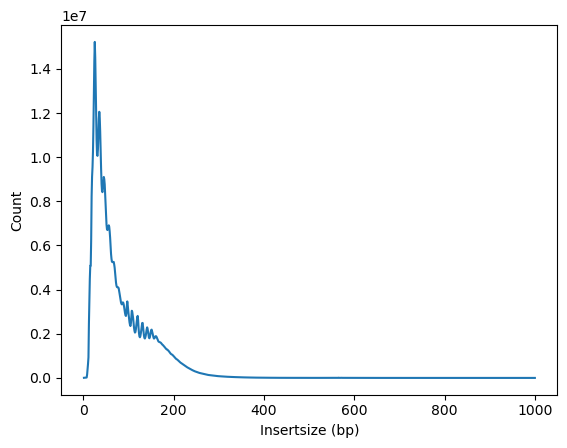

In [12]:
if (qc_columns['mean_insertsize'] is None or qc_columns['insertsize_count'] is None) and calc_mean_insertsize:
    
    if use_bam:
        atac.add_insertsize(adata, bam=bam_file, barcode_tag=barcode_tag)     
    else:
        atac.add_insertsize(adata, fragments=fragments_file, barcode_tag=barcode_tag)
        
    # update column dictionary
    qc_columns['mean_insertsize'] = 'mean_insertsize'
    qc_columns['insertsize_count'] = 'insertsize_count'
    
    # update infoprocess table
    build_legend(adata, 'mean_insertsize', 'mean_insertsize')
    build_legend(adata, 'insertsize_count', 'insertsize_count')
    
    atac.plot_insertsize(adata, barcodes=None)
    
adata.obs

### 3. promotor enrichment 

In [13]:
if qc_columns['n_fragments_in_promoters'] is None and calc_promotor_enrichment:
    
    if use_bam:
        overlap.pct_fragments_in_promoters(adata, gtf_file=promoters_gtf, species=species, bam_file=bam_file, cb_col=None, nproc=1, cb_tag=barcode_tag)
    else:
        overlap.pct_fragments_in_promoters(adata, gtf_file=promoters_gtf, species=species, fragments_file=fragments_file, cb_col=None, nproc=1, cb_tag=barcode_tag)
    
    # n_total_fragments, n_fragments_in_promoters, pct_fragments_in_promoters
    # update column dictionary
    qc_columns['n_total_fragments'] = 'n_total_fragments'
    qc_columns['n_fragments_in_promoters'] = 'n_fragments_in_promoters'
    qc_columns['pct_fragments_in_promoters'] = 'pct_fragments_in_promoters'
    # update infoprocess table
    build_legend(adata, 'n_total_fragments', 'n_total_fragments')
    build_legend(adata, 'n_fragments_in_promoters', 'n_fragments_in_promoters')
    build_legend(adata, 'pct_fragments_in_promoters', 'pct_fragments_in_promoters')
    

Converting GTF to BED...
Finding overlaps...
Calculating percentage...


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Progress:   0%|          | 0/81 [00:00<?, ?it/s]

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Progress:   0%|          | 0/745 [00:00<?, ?it/s]

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding results to adata object...
Done


## Inspect adata.obs

In [14]:
adata.obs

,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize,n_fragments_in_promoters,n_total_fragments,pct_fragments_in_promoters
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,sample1,2172,7.683864,6863.0,8.834045,58672,65.67,2954,58773,0.050261
AACACTGACATGGCCC-sample1,2984,2716,4065,1765,1107,2592,1374,1751,2946,2470,...,sample1,5574,8.626048,13178.0,9.486380,28738,91.21,4484,28743,0.156003
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,sample1,3766,8.234034,8689.0,9.069928,32958,80.16,2138,32961,0.064865
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,sample1,401,5.996452,973.0,6.881412,19866,75.62,866,19883,0.043555
CATCCGTACCCTCCTA-sample1,3038,4102,3801,3877,2740,3516,1378,1737,1738,2111,...,sample1,6556,8.788288,17439.0,9.766521,27481,77.92,3085,27483,0.112251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACCACTCTGAAGGTC-sample8,559,337,1277,405,833,307,486,635,38,605,...,sample1,1605,7.381502,3151.0,8.055793,6577,113.95,1075,6577,0.163448
GCCAATTGACAGCACC-sample8,1790,3518,5730,1893,2581,2134,2472,1814,2404,3073,...,sample1,7049,8.860783,16304.0,9.699227,33450,80.25,4625,33456,0.138241
GCGTCGATGTGTCACA-sample8,52,32,1709,3924,2324,2026,18,1344,2029,1563,...,sample1,1264,7.142827,2617.0,7.870166,16089,84.17,878,16097,0.054544
GACTACCCTCGCCACA-sample8,226,258,378,152,301,206,194,203,143,90,...,sample1,730,6.594413,1384.0,7.233456,2099,126.01,225,2099,0.107194


## Save adata to .h5ad

In [15]:
adata_output = tree.assembled_anndata
adata_output

'/mnt/workspace/jdetlef/ext_ana/processed/all/assembling/anndata/all.h5ad'

In [16]:
#Saving the data
cr.build_infor(adata, "Test_number", test)
cr.build_infor(adata, "Anndata_path", output_dir)

adata_output = tree.assembled_anndata
adata.write(filename=adata_output)

In [17]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '1_assembling.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.assemble_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)

'/mnt/workspace/jdetlef/ext_ana/processed/all/assembling/1_assembling.ipynb'